# Taking the power spectra of the signals

In [1]:
#baseDIR = '/home/pataki/synapse/gitParkinson/' # base directory of the github repo
#uncomment the line above (+ update) if you are running this notebook in an empty namespace
try: baseDIR
except NameError:
    print('Error: baseDIR not found!')

In [2]:
cd $baseDIR/sub2.2_dysk/

/home/pataki/synapse/gitParkinson/sub2.2_dysk


In [3]:
%run -i ../src/helperFuncs.py

In [4]:
%matplotlib inline

In [5]:
mainDF = mainDFCreator('dyskinesiaScore')

Train shape: (1556, 12)
Test shape:  (660, 12)
Merged:      (2216, 12)


In [6]:
mainDF = mainDFtrimmer(mainDF, fileMinLen=1, plot=False)

Remained shape: (2143, 14)


In [7]:
ftGroupDF = pd.DataFrame()

parityInv = {0:1, 1:0} # sampling for Fourier odd/even
for i in pb(range(len(mainDF))):
    ID = mainDF.dataFileHandleId.tolist()[i]
    x = FFTbyID(ID, 'X', mainDF)
    y = FFTbyID(ID, 'Y', mainDF)
    z = FFTbyID(ID, 'Z', mainDF)
    
    fileLen = len(dataByID(ID, mainDF))
    hz = np.fft.rfftfreq(d=0.02, n = fileLen)[parityInv[fileLen%2]:] # frequencies
    FTdf = pd.DataFrame({'hz':hz, 'X':x, 'Y':y, 'Z':z})
    FTdf = FTdf[FTdf.hz >= 4.0] # lower freq cutoff
    FTdf = FTdf[FTdf.hz < 20]   # upper freq cutoff
    FTdf['hz'] = [int(i*2)/2 for i in FTdf.hz] # groupby freq (0.5 hz bins)
    FTdf = FTdf.groupby('hz').mean()
    allPowDF = pd.DataFrame(FTdf.sum(0)).rename(columns = {0:'allPower'}).T
    FTdf = FTdf.div(FTdf.sum(0)).append(allPowDF)
    
    xDF = FTdf[['X']].T
    xDF.columns = ['X_' + str(i) for i in xDF.columns.tolist()]

    yDF = FTdf[['Y']].T
    yDF.columns = ['Y_' + str(i) for i in yDF.columns.tolist()]

    zDF = FTdf[['Z']].T
    zDF.columns = ['Z_' + str(i) for i in zDF.columns.tolist()]

    allDF = pd.concat([xDF.reset_index(drop=True), yDF.reset_index(drop=True)], axis=1)
    allDF = pd.concat([allDF, zDF.reset_index(drop=True)], axis = 1)

    allDF['dataFileHandleId'] = ID
    ftGroupDF = ftGroupDF.append(allDF)

100%|██████████| 2143/2143 [02:28<00:00,  7.35it/s]


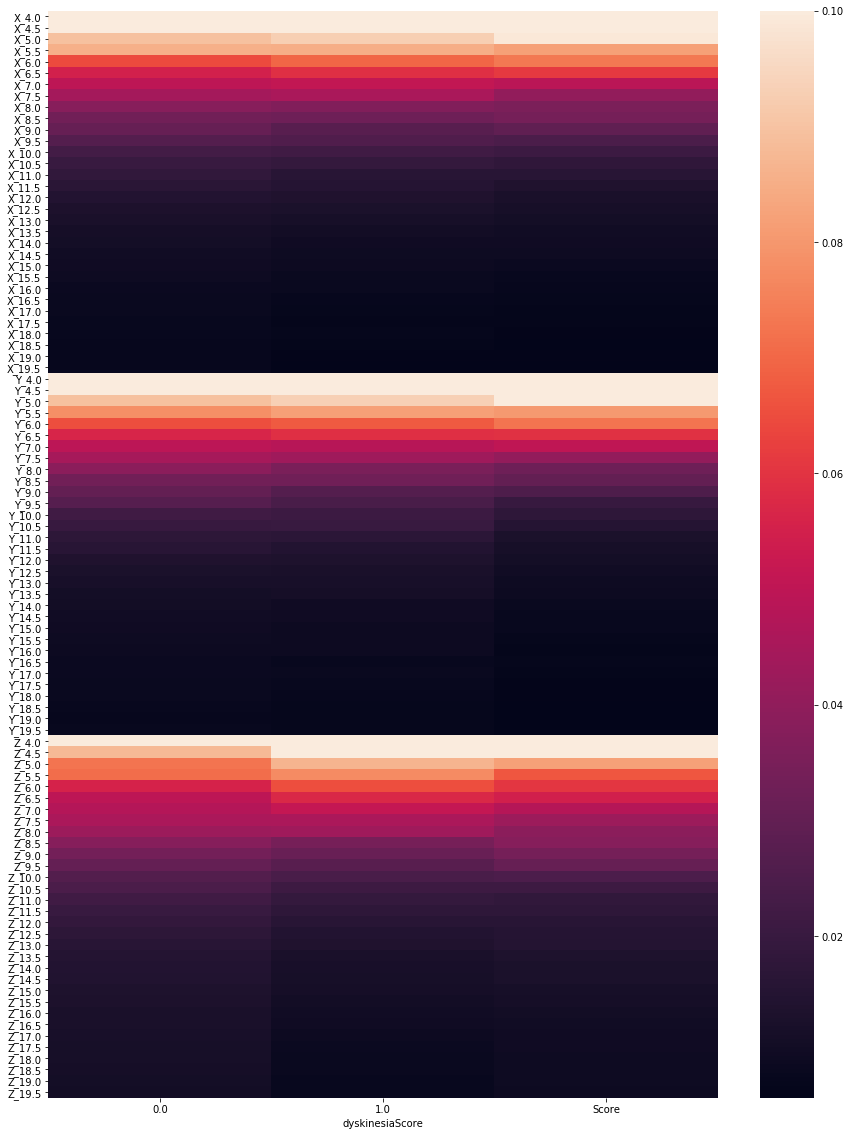

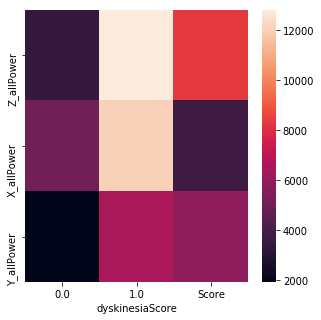

dyskinesiaScore,0.0,1.0,Score
Z_allPower,3433.596157,12801.866060,8299.709811
X_allPower,5081.282227,12050.341780,3751.430753
Y_allPower,1928.082141,6523.741628,5841.047195


In [8]:
plt.rcParams['figure.figsize']=(15,20)
stats = pd.merge(ftGroupDF, mainDF[['dyskinesiaScore', 'dataFileHandleId']], on = 'dataFileHandleId').groupby('dyskinesiaScore').mean()
stats.pop('Z_allPower');
stats.pop('X_allPower');
stats.pop('Y_allPower');
stats.pop('dataFileHandleId');

sns.heatmap(stats.T, vmax=0.1)
plt.show()

plt.rcParams['figure.figsize']=(5,5)
stats = pd.merge(ftGroupDF, mainDF, on = 'dataFileHandleId').groupby('dyskinesiaScore').mean()
sns.heatmap(stats[['Z_allPower', 'X_allPower', 'Y_allPower']].T)
plt.show()
stats[['Z_allPower', 'X_allPower', 'Y_allPower']].T

In [9]:
xCols = [i for i in ftGroupDF.columns.tolist() if('X_' in i)] 
yCols = [i for i in ftGroupDF.columns.tolist() if('Y_' in i)] 
zCols = [i for i in ftGroupDF.columns.tolist() if('Z_' in i)] 
xCols.sort()
yCols.sort()
zCols.sort()

In [10]:
xCols = xCols[:-1] # drop X_allPower
yCols = yCols[:-1]
zCols = zCols[:-1]

In [11]:
ftGroupDF = ftGroupDF.reset_index(drop=True)

In [12]:
xyErrList = []
xzErrList = []
yzErrList = []

for i in pb(range(len(ftGroupDF))):
    xyErr = sum((np.array(ftGroupDF.loc[i][xCols].tolist()) - np.array(ftGroupDF.loc[i][yCols].tolist()))**2)*50
    xzErr = sum((np.array(ftGroupDF.loc[i][xCols].tolist()) - np.array(ftGroupDF.loc[i][zCols].tolist()))**2)*50
    yzErr = sum((np.array(ftGroupDF.loc[i][yCols].tolist()) - np.array(ftGroupDF.loc[i][zCols].tolist()))**2)*50
# MSE of the any two Fourier curve
    xyErrList.append(xyErr)
    xzErrList.append(xzErr)
    yzErrList.append(yzErr)
ftGroupDF['xyFTerr'] = xyErrList
ftGroupDF['xzFTerr'] = xzErrList
ftGroupDF['yzFTerr'] = yzErrList

100%|██████████| 2143/2143 [00:11<00:00, 183.58it/s]


In [13]:
ftGroupDF['X_allPower'] = np.log(ftGroupDF.X_allPower.tolist())
ftGroupDF['Y_allPower'] = np.log(ftGroupDF.Y_allPower.tolist())
ftGroupDF['Z_allPower'] = np.log(ftGroupDF.Z_allPower.tolist())

In [14]:
mainDF = mainDFCreator('dyskinesiaScore')
mainDF = mainDFtrimmer(fileMinLen=1, inputDF=mainDF, plot=False)

Train shape: (1556, 12)
Test shape:  (660, 12)
Merged:      (2216, 12)
Remained shape: (2143, 14)


In [15]:
ftGroupDF = pd.merge(ftGroupDF.fillna(ftGroupDF.mean()), mainDF[['dataFileHandleId']], how = 'outer')

In [16]:
ftGroupDF = ftGroupDF.fillna(ftGroupDF.mean())

In [17]:
ftGroupDF.to_csv('featureDB/fourierFeatures.tsv', sep='\t', index=False)